# Raw example of API usage in Python of the C++ wrapper classes

We do not rely on any python overlay for now, as we want to expose how C++ pybind11 classes look like from a python point of view.

The `import pyclesperanto as pycle` will import the python package directly linked to the `_pyclesperanto.so` library file.

This notebook is mainly here to highlyt what is currently visible from the C++ and provide discussion material for the design and implementation of a pure python layer API over it, similar to pyclesperanto-prototype for example.

## Imports

In [1]:
import numpy as np
from pyclesperanto import _pyclesperanto as pycle

## Device allocation

After imports, we need to allocated a device. This requires to instanciate a gpu object.

In [2]:
device = pycle.gpu()
print(device.info()) # the print is required in order to keep the formating from c++
                     # the () are required as info() it is a c++ class method

[NVIDIA CUDA - NVIDIA GeForce GTX 1050 Ti]
	DevicedeviceType: 4
	MaxComputeUnits: 6
	MaxClockFrequency: 1455
	Version: OpenCL 3.0 CUDA
	Extensions: cl_khr_global_int32_base_atomics cl_khr_global_int32_extended_atomics cl_khr_local_int32_base_atomics cl_khr_local_int32_extended_atomics cl_khr_fp64 cl_khr_3d_image_writes cl_khr_byte_addressable_store cl_khr_icd cl_khr_gl_sharing cl_nv_compiler_options cl_nv_device_attribute_query cl_nv_pragma_unroll cl_nv_copy_opts cl_nv_create_buffer cl_khr_int64_base_atomics cl_khr_int64_extended_atomics cl_khr_device_uuid cl_khr_pci_bus_info
	GlobalMemorySizeInBytes: 4233035776
	LocalMemorySizeInBytes: 49152
	MaxMemoryAllocationSizeInBytes: 1058258944
	MaxWorkGroupSize: 1024



It is also possible to select a specific device using a string key word contained in its name, for example:

In [3]:
device.select_device("GTX")
print(device.info())

[NVIDIA CUDA - NVIDIA GeForce GTX 1050 Ti]
	DevicedeviceType: 4
	MaxComputeUnits: 6
	MaxClockFrequency: 1455
	Version: OpenCL 3.0 CUDA
	Extensions: cl_khr_global_int32_base_atomics cl_khr_global_int32_extended_atomics cl_khr_local_int32_base_atomics cl_khr_local_int32_extended_atomics cl_khr_fp64 cl_khr_3d_image_writes cl_khr_byte_addressable_store cl_khr_icd cl_khr_gl_sharing cl_nv_compiler_options cl_nv_device_attribute_query cl_nv_pragma_unroll cl_nv_copy_opts cl_nv_create_buffer cl_khr_int64_base_atomics cl_khr_int64_extended_atomics cl_khr_device_uuid cl_khr_pci_bus_info
	GlobalMemorySizeInBytes: 4233035776
	LocalMemorySizeInBytes: 49152
	MaxMemoryAllocationSizeInBytes: 1058258944
	MaxWorkGroupSize: 1024



In [4]:
help(pycle.gpu) # help documentation generated from the class, 
                  # it reveal the associated methods and their signature

Help on class gpu in module pyclesperanto._pyclesperanto:

class gpu(pybind11_builtins.pybind11_object)
 |  gpu class wrapper
 |  -----------------------
 |  select_device()
 |  info()
 |  name()
 |  score()
 |  set_wait_for_kernel_to_finish()
 |  
 |  create()
 |  push()
 |  pull()
 |  
 |  Method resolution order:
 |      gpu
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: pyclesperanto._pyclesperanto.gpu) -> None
 |      
 |      GPU default constructor
 |      
 |      2. __init__(self: pyclesperanto._pyclesperanto.gpu, t_device_name: str, t_device_type: str = 'all') -> None
 |      
 |      GPU constructor
 |  
 |  create(...)
 |      create(self: pyclesperanto._pyclesperanto.gpu, dimensions: numpy.ndarray[numpy.float32], t_type: str = 'buffer') -> PyData
 |      
 |      create an empty gpu array
 |  
 |  info(..

The `gpu` class is in charge of managing the device interation, this includes the `create`, `push`, `pull` operations.
- create(array, string) allows to allocate memory on the device corresponding to the shape passed in arguments
- push(array, string) also create and write the memory on the device from a numpy array shape and data past in argument
- pull(gpu_array) will read the memory from the device and return a numpy array

With the exception of `pull`, all have a string arguments which allows to decide the type of memory hold is used in the device, a `buffer` or an `image`. The default behaviour is `buffer`.

## host to device to host behaviour

The GPU objects defined by the python class `data` can be buffers (default) or images, and will for now only contain float32 data type.
Same as the `gpu` class, it comes with several methods similar to the python numpy class

In [5]:
help(pycle.data)

Help on class data in module pyclesperanto._pyclesperanto:

class data(pybind11_builtins.pybind11_object)
 |  data class wrapper
 |  -----------------------
 |  ndim()
 |  size()
 |  shape()
 |  shape_xyz()
 |  shape_zyx()
 |  dtype()
 |  
 |  Method resolution order:
 |      data
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: pyclesperanto._pyclesperanto.data) -> None
 |  
 |  dtype(...)
 |      dtype(self: pyclesperanto._pyclesperanto.data) -> str
 |      
 |      return object data type (float, double, etc.)
 |  
 |  ndim(...)
 |      ndim(self: pyclesperanto._pyclesperanto.data) -> int
 |      
 |      return object dimensionality
 |  
 |  shape(...)
 |      shape(self: pyclesperanto._pyclesperanto.data) -> List[int[3]]
 |      
 |      return object shape (z,y,x)
 |  
 |  shape_xyz(...)
 |      shape_xyz(self: pyclesperanto._pyclesperanto.data) -> List[int[3]]
 |      
 |      return ob

The gpu device class is the only way to properly create a GPU object throught the commande usage `push` and `create`.
And the only way to read its contend is to first `pull` it from the device into the host memory 

In [6]:
# we create an array on the host side
input_array = np.random.rand(2,5,10)
# we push the array from the host to the device as a buffer
gpu_input_array = device.push(input_array, "buffer")
# we create an output memory space (an image, not a buffer this time) on the device of the same size as the input
gpu_output_array = device.create(input_array.shape, "image")
# we can read then from device to host
output_array = device.pull(gpu_input_array)

In [7]:
print("host input numpy array:\t", type(input_array), input_array.shape, input_array.dtype)
print("device buffer array:\t", type(gpu_input_array), gpu_input_array.shape(), gpu_input_array.dtype())
print("device image array:\t", type(gpu_output_array), gpu_output_array.shape(), gpu_output_array.dtype())
print("host output numpy array:", type(output_array), output_array.shape, output_array.dtype)

host input numpy array:	 <class 'numpy.ndarray'> (2, 5, 10) float64
device buffer array:	 <class 'pyclesperanto._pyclesperanto.data'> [2, 5, 10] float
device image array:	 <class 'pyclesperanto._pyclesperanto.data'> [2, 5, 10] float
host output numpy array: <class 'numpy.ndarray'> (2, 5, 10) float32


When push or create on the device, both methods automatically flip the data dimensions from numpy standard (zyx) to C++ (xyz), it is flipped again when reading from device to host.
Few details to notice:
- C++ class methods requires `()`
- C++ `shape()` method return a list, not a tuple like numpy
- C++ `dtype()` method display the type according to C++ native types, here `float` corresponding to `float32`
- pull return array type is `float32` not `float64` like the input was

it is possible to display the shape in the standard we wish, though is is purely visual

In [8]:
print("default display:", type(gpu_input_array), gpu_input_array.shape(), gpu_input_array.dtype())
print("zyx display:", type(gpu_input_array), gpu_input_array.shape_zyx(), gpu_input_array.dtype())
print("xyz zdisplay:", type(gpu_input_array), gpu_input_array.shape_xyz(), gpu_input_array.dtype())

default display: <class 'pyclesperanto._pyclesperanto.data'> [2, 5, 10] float
zyx display: <class 'pyclesperanto._pyclesperanto.data'> [2, 5, 10] float
xyz zdisplay: <class 'pyclesperanto._pyclesperanto.data'> [10, 5, 2] float


More example for various data shape to see code behaviour:

In [9]:
print("Test with shape (1,5,10)")
input_array = np.random.rand(1,5,10)
gpu_input_array = device.push(input_array)
output_array = device.pull(gpu_input_array)
print("\thost input array:", type(input_array), input_array.shape, input_array.dtype)
print("\tdevice array:", type(gpu_input_array), gpu_input_array.shape(), gpu_input_array.dtype())
print("\thost output array:", type(output_array), output_array.shape, output_array.dtype)

print("Test with shape (5,10)")
input_array = np.random.rand(5,10)
gpu_input_array = device.push(input_array)
output_array = device.pull(gpu_input_array)
print("\thost input array:", type(input_array), input_array.shape, input_array.dtype)
print("\tdevice array:", type(gpu_input_array), gpu_input_array.shape(), gpu_input_array.dtype())
print("\thost output array:", type(output_array), output_array.shape, output_array.dtype)

print("Test with shape (1,1,10)")
input_array = np.random.rand(1,1,10)
gpu_input_array = device.push(input_array)
output_array = device.pull(gpu_input_array)
print("\thost input array:", type(input_array), input_array.shape, input_array.dtype)
print("\tdevice array:", type(gpu_input_array), gpu_input_array.shape(), gpu_input_array.dtype())
print("\thost output array:", type(output_array), output_array.shape, output_array.dtype)

print("Test with shape (10)")
input_array = np.random.rand(10)
gpu_input_array = device.push(input_array)
output_array = device.pull(gpu_input_array)
print("\thost input array:", type(input_array), input_array.shape, input_array.dtype)
print("\tdevice array:", type(gpu_input_array), gpu_input_array.shape(), gpu_input_array.dtype())
print("\thost output array:", type(output_array), output_array.shape, output_array.dtype)

print("Test with shape (1,1,1)")
input_array = np.random.rand(1,1,1)
gpu_input_array = device.push(input_array)
output_array = device.pull(gpu_input_array)
print("\thost input array:", type(input_array), input_array.shape, input_array.dtype)
print("\tdevice array:", type(gpu_input_array), gpu_input_array.shape(), gpu_input_array.dtype())
print("\thost output array:", type(output_array), output_array.shape, output_array.dtype)

print("Test with shape (1)")
input_array = np.random.rand(1)
gpu_input_array = device.push(input_array)
output_array = device.pull(gpu_input_array)
print("\thost input array:", type(input_array), input_array.shape, input_array.dtype)
print("\tdevice array:", type(gpu_input_array), gpu_input_array.shape(), gpu_input_array.dtype())
print("\thost output array:", type(output_array), output_array.shape, output_array.dtype)

Test with shape (1,5,10)
	host input array: <class 'numpy.ndarray'> (1, 5, 10) float64
	device array: <class 'pyclesperanto._pyclesperanto.data'> [1, 5, 10] float
	host output array: <class 'numpy.ndarray'> (5, 10) float32
Test with shape (5,10)
	host input array: <class 'numpy.ndarray'> (5, 10) float64
	device array: <class 'pyclesperanto._pyclesperanto.data'> [1, 5, 10] float
	host output array: <class 'numpy.ndarray'> (5, 10) float32
Test with shape (1,1,10)
	host input array: <class 'numpy.ndarray'> (1, 1, 10) float64
	device array: <class 'pyclesperanto._pyclesperanto.data'> [1, 1, 10] float
	host output array: <class 'numpy.ndarray'> (10,) float32
Test with shape (10)
	host input array: <class 'numpy.ndarray'> (10,) float64
	device array: <class 'pyclesperanto._pyclesperanto.data'> [1, 1, 10] float
	host output array: <class 'numpy.ndarray'> (10,) float32
Test with shape (1,1,1)
	host input array: <class 'numpy.ndarray'> (1, 1, 1) float64
	device array: <class 'pyclesperanto._pyc

## Kernels usage 

Here kernels would correspond to an image processing operation to be executed on the device. By convention nearly all kernels take as parameters as input and an output, both already defined by the user.

Their visibility through the pyclesperanto package is direct, for example `from pyclesperanto import add_image_and_scalar` will make the `add_image_and_scalar` kernel available. 

In [10]:
# host data
input_array = np.random.rand(2,3,4).astype(np.float32)

# device input and output
gpu_input  = device.push(input_array)
gpu_output = device.create(input_array.shape)

# execute kernel
pycle.add_image_and_scalar(device=device, input=gpu_input, output=gpu_output, scalar=100)

# read output from device to host
result_array = device.pull(gpu_output)
valid_array = input_array + 100

In [11]:
print( "gpu output=", np.sum(result_array), ", vs host output=" , np.sum(valid_array) )

gpu output= 2412.4607 , vs host output= 2412.4607


Important point to raise:
- All kernel operation first argument is always the device.
- C++ side already allows to define arguments tags, those will normally mimic the one used in the CLIc
- As arguments tags are available, the arguments order is flexible

In [12]:
pycle.add_image_and_scalar(output=gpu_output, device=device, scalar=100, input=gpu_input)
print( "gpu output=", np.sum(result_array), ", vs host output=" , np.sum(valid_array) )

gpu output= 2412.4607 , vs host output= 2412.4607


Currently these kernels are organised per tiers (tier1, tier2, etc.) depending on dependency. Tier2 kernel will requiere one or more kernel from tier1, etc.
Their are not linked to any class so far and are directly accessible as function of the package.
This is the reason why the device is required as a parameter, but it offers a better flexibility of imports.

Documentation and signature is available with the help function

In [13]:
help(pycle.add_image_and_scalar)

Help on built-in function add_image_and_scalar in module pyclesperanto._pyclesperanto:

add_image_and_scalar(...) method of builtins.PyCapsule instance
    add_image_and_scalar(device: pyclesperanto._pyclesperanto.gpu, input: pyclesperanto._pyclesperanto.data, output: pyclesperanto._pyclesperanto.data, scalar: float) -> None
    
    add scalar value to image



## Package overview

Finally a more global view of the package is also available with the help function directly on the pyclesperanto package

In [14]:
help(pycle)

Help on module pyclesperanto._pyclesperanto in pyclesperanto:

NAME
    pyclesperanto._pyclesperanto

DESCRIPTION
    tier4 wrapper
    -----------------------
    threshold_otsu()
    connected_component_labelling_box()

CLASSES
    pybind11_builtins.pybind11_object(builtins.object)
        data
        gpu
    
    class data(pybind11_builtins.pybind11_object)
     |  data class wrapper
     |  -----------------------
     |  ndim()
     |  size()
     |  shape()
     |  shape_xyz()
     |  shape_zyx()
     |  dtype()
     |  
     |  Method resolution order:
     |      data
     |      pybind11_builtins.pybind11_object
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(...)
     |      __init__(self: pyclesperanto._pyclesperanto.data) -> None
     |  
     |  dtype(...)
     |      dtype(self: pyclesperanto._pyclesperanto.data) -> str
     |      
     |      return object data type (float, double, etc.)
     |  
     |  ndim(...)
     |   

## Test with a real image

In [15]:
from skimage.io import imread, imshow

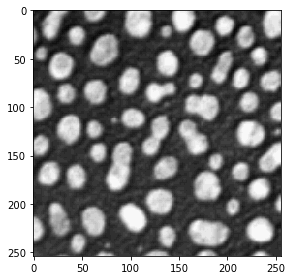

In [16]:
image = imread("blobs.tif")
imshow(image)

In [17]:
gpu_image = device.push(image)
gpu_output = device.create(image.shape)
pycle.gaussian_blur(device=device, input=gpu_image, output=gpu_output, sigma_x=3, sigma_y=3, sigma_z=0)

/home/stephane/Libraries/anaconda3/envs/opencl/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


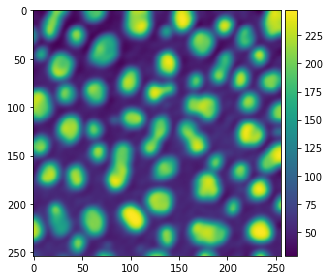

In [18]:
result = device.pull(gpu_output)
imshow(result)